# Methods & Results

In [6]:
install.packages("tidyverse")
install.packages("tidymodels")
install.packages("themis")
install.packages("cowplot")
install.packages("ISLR")
install.packages("repr")
install.packages("GGally")
install.packages("themis")

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



In [7]:
install.packages("kknn")
#try not to run this cell its crashing for some reason

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



In [8]:
set.seed(1)

library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
library(GGally)
library(ISLR)
library(themis)
options(repr.matrix.max.rows = 6)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.2.0 ──

✔ broom        0.7.12     ✔ rsample      0.1.1 
✔ dials        1.0.0      ✔ tune         0.2.0 
✔ infer        1.0.2      ✔ workflows    0.2.6 
✔ modeldata    0.1.1      ✔ workflowsets 0.2.1 
✔ parsnip      1.0.0      ✔ yardstick    1.0.0 
✔ recipes      0.2.0      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filte

## Reading, Cleaning, Wrangling Data 
We first read the file from the web using read_csv. Our initial analysis of the raw dataset revealed eight numeric variables and one binary (target) variable. As there was an absence of column names, we assigned the provided variable names and changed our target variable from a double to a factor data type.

In [9]:
# READING THE FILE FROM THE WEB, THE FILE DOES NOT CONTAIN COLUMN NAMES 
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip", temp)
pulsar_file <- unz(temp, "HTRU_2.csv")
pulsar <- read_csv(pulsar_file, col_names = FALSE)

# WE ARE ASSIGNING COLUMN NAMES ACCORDING TO THE INFORMATION GIVEN FROM THE DATAFILE
colnames(pulsar) <- c("mean_ip", "std_ip", "kurt_ip", "skew_ip", "mean_dm_snr", "std_dm_snr", "kurt_dm_snr", "skew_dm_snr", "class")

# WE ARE CHANGING CLASS TO A FACTOR VARIABLE BECAUSE THAT IS THE CATEGORICAL VARIABLE THAT WE ARE TRYING TO 
# PREDICT FOR 
pulsar_mutate <- pulsar %>%
                mutate(class = as_factor(class))
pulsar_mutate

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_ip,std_ip,kurt_ip,skew_ip,mean_dm_snr,std_dm_snr,kurt_dm_snr,skew_dm_snr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


## Summary of Data
1. Coded for table a table with the average of all predictor variables to determine if scaling is needed. We decided to scale our chosen predictor variables since their mean differed by more than 10 fold (kurt_ip: 0.4778573 and mean_dm_snr: 12.6144).
2. We split our data into train and test sets and stratified by class to ensure that equivalent proportions of each class is in the train and test set
3. Using ggpairs(), we visualized the correlation between the 8 potential predictor variables, from this we decided to choose kurt_ip and mean_dm_snr as the predictor variables that we will use for our classification model as the boxplots of both of these variables shows great distinction between class 0 (non-pulsar) and class 1 (pulsar). 
4. To get an idea of the proportion of each class in the train data set, we used group by and summarize to determine the counts of each class. The ratio was 12200:1223, non-pulsar to pulsar data points. This indicated to us that there is severe class imbalance and that we either have to upsample or downsample to balance the classes as K-nearest neighbors classification does not work well when classes are imbalanced. 

In [10]:
# 1: AVERAGE OF EACH COLUMN IS CALCULATED SO THAT WE CAN DETERMINE IF SCALING IS NECESSARY FOR OUR MODEL 
pulsar_with_column_means <- pulsar %>%
                select(mean_ip:skew_dm_snr) %>%
                map_df(mean)
pulsar_with_column_means

mean_ip,std_ip,kurt_ip,skew_ip,mean_dm_snr,std_dm_snr,kurt_dm_snr,skew_dm_snr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
111.08,46.54953,0.4778573,1.770279,12.6144,26.32651,8.303556,104.8577


In [11]:
# 2: SPLITTING OUR DATA INTO TRAIN AND TEST SETS 
pulsar_split <- initial_split(pulsar_mutate, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split) 
pulsar_test <- testing(pulsar_split)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



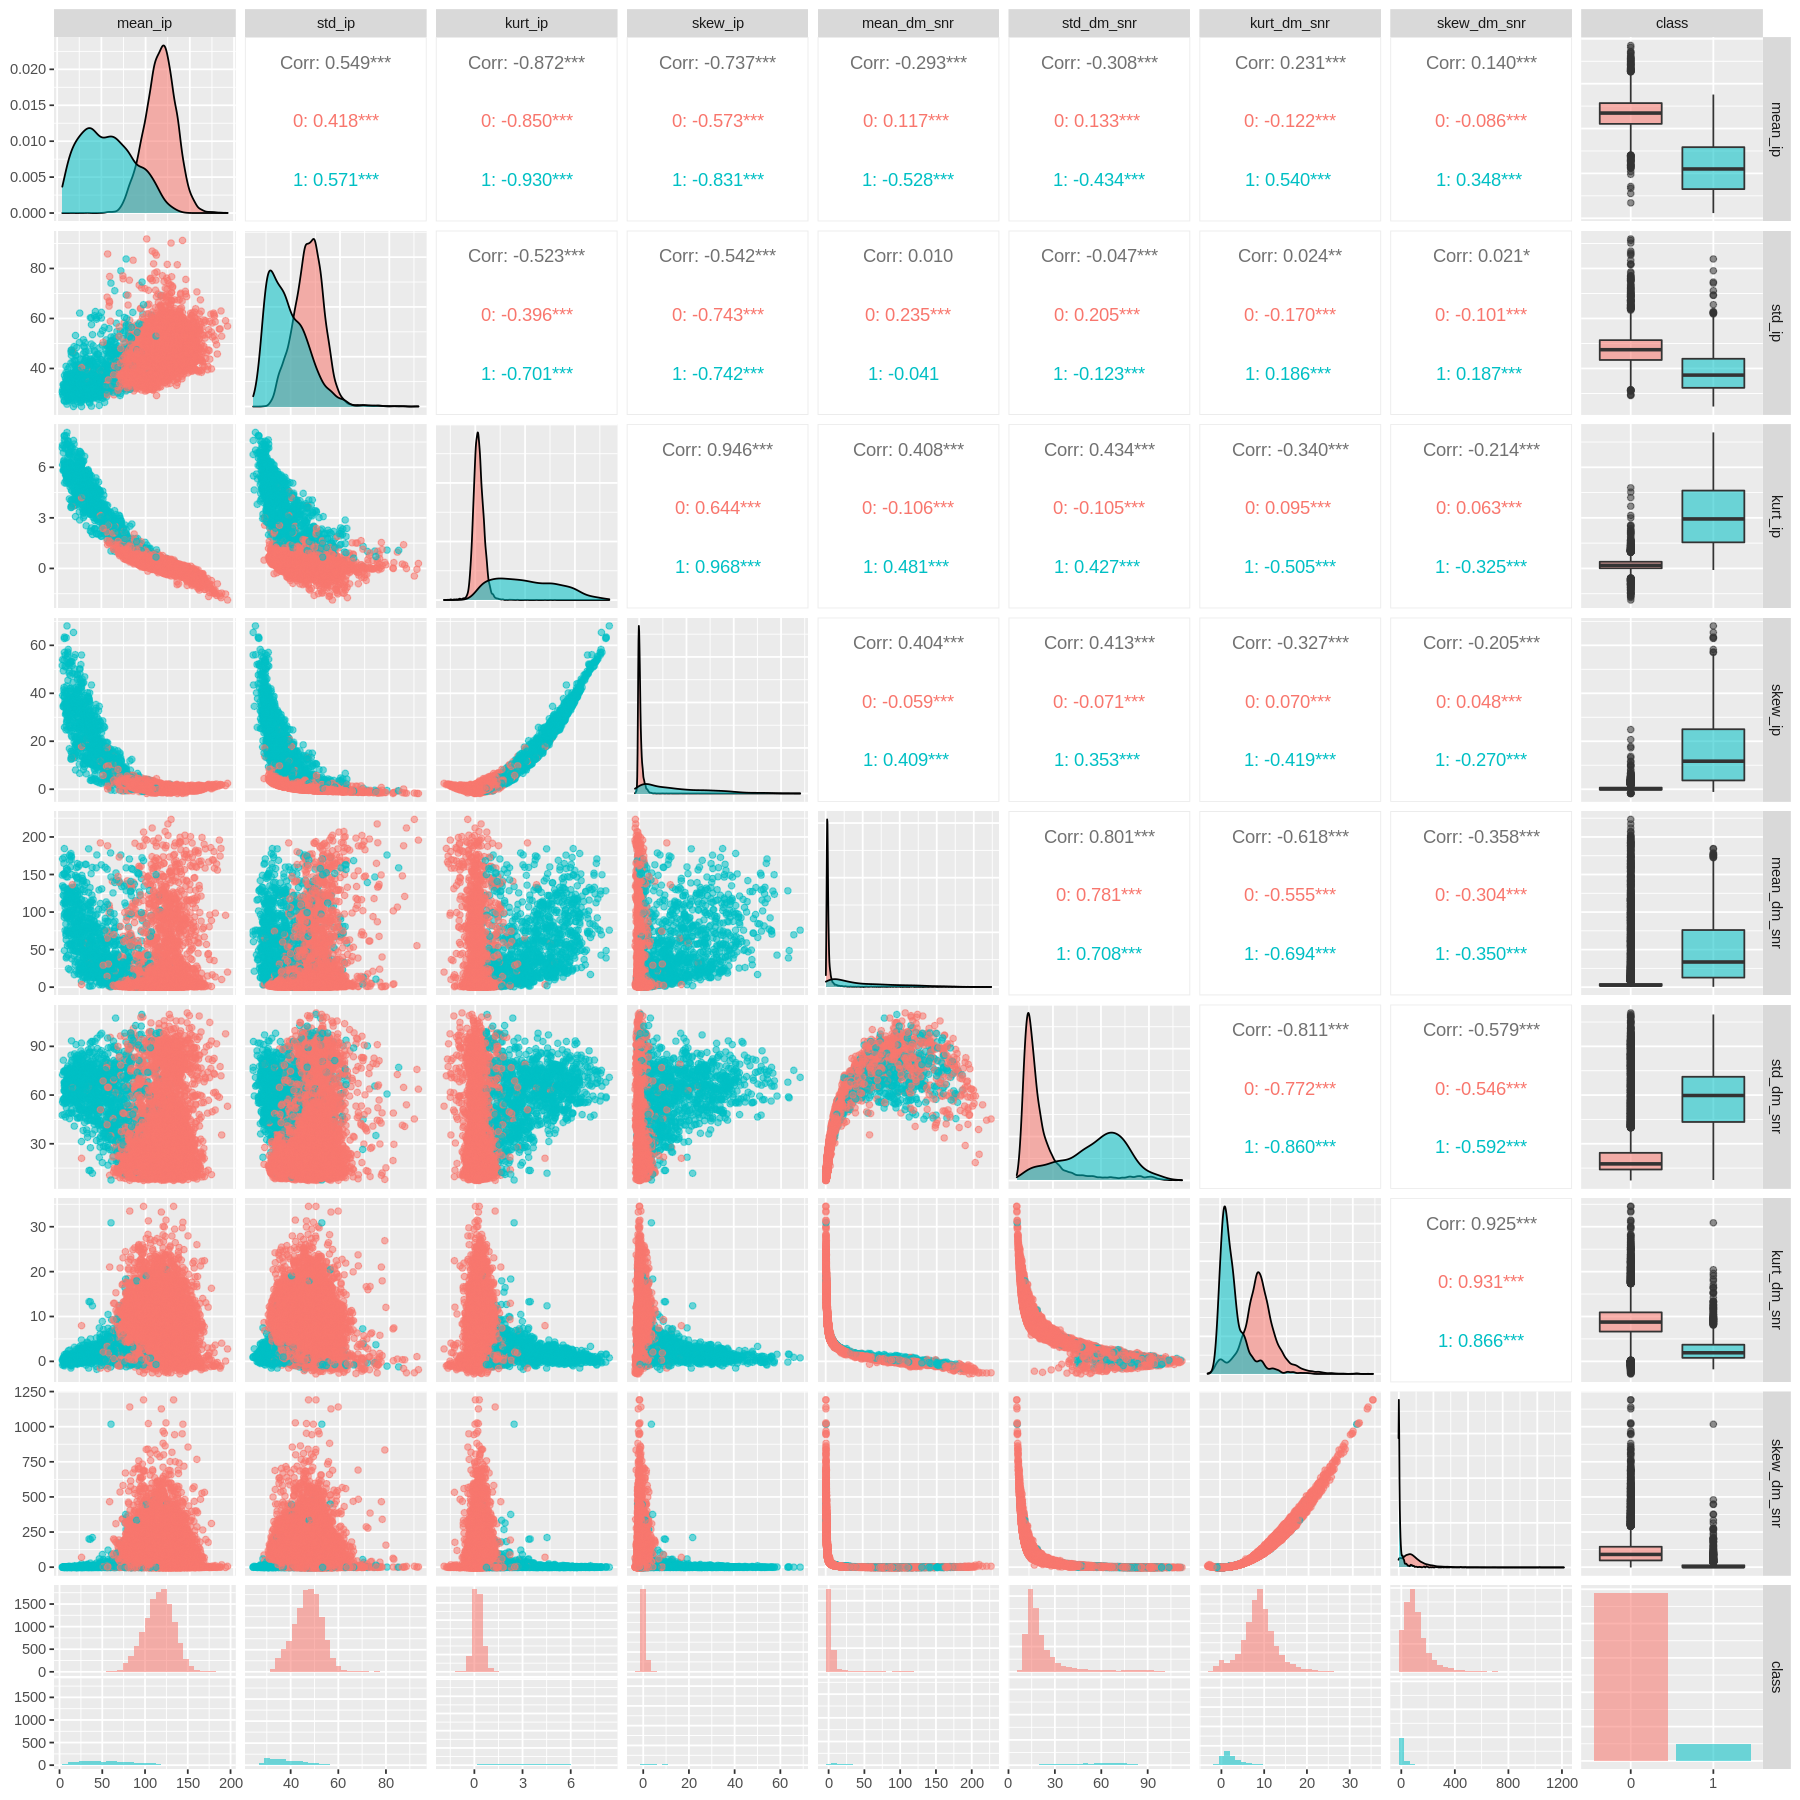

In [12]:
# 3: GGPAIRS() TO DECIDE WHICH PREDICTOR VARIABLES SEEM TO HAVE THE MOST DISTINCTION BETWEEN THE TWO CLASSES 
options(repr.plot.height = 15, repr.plot.width = 15)
correlation <- ggpairs(pulsar_train, mapping = aes(color = class, alpha = 0.5))
correlation
# options(repr.plot.height = 10, repr.plot.width = 10)


In [13]:
# 4: PULSAR OBSERVATION COUNTS FOR EACH CLASS 
count_train_pulsar <- pulsar_train %>%
    group_by(class) %>%
    summarize(n = n())
count_train_pulsar

# IT IS VERY IMBALANCED SO WE WILL HAVE TO FIRST BALANCE OUR CLASSES BEFORE BUILDING OUR MODEL 


class,n
<fct>,<int>
0,12200
1,1223


## Recipes
We downsampled our training data set when coding for our recipe, we set the under_ratio to be 1 and downsampled based on the variable class, this essentially cuts down the data points that are class 0 in the training set till there is an equal amount of class 0 and class 1 data points. We decided to downsample instead of upsample because we are left with a smaller training set (2446 data points for downsampling vs. 24400 data points if we upsample) and this allows our code to run faster. 
We had to code for two recipes since we wanted to be able to plot our unscaled downsampled data for interpretability and this requires prep() and bake(), whereas the recipe that we have designated for the building of the model is scaled and does not have prep() and bake() since workflow automatically does that for us. 

In [14]:
# ONLY ACCOUNTING FOR KURT_IP AND MEAN_DM_SNR VARIABLES 
# DUE TO CLASS IMBALANCE, WE HAVE TO USE STEP_DOWNSAMPLE IN OUR RECIPE TO BALANCE OUR CLASSES 

pulsar_recipe <- recipe(class ~ kurt_ip + mean_dm_snr, data = pulsar_train) %>%
  step_downsample(class, under_ratio = 1, skip = TRUE) %>%   
  step_scale(all_predictors()) %>%
  step_center(all_predictors())
#PULSAR_RECIPE WILL BE USED FOR WORKFLOW; DOES NOT HAVE PREP AND BAKE 

downsampled_pulsar_train <- recipe(class ~ kurt_ip + mean_dm_snr, data = pulsar_train) %>%
  step_downsample(class, under_ratio = 1, skip = FALSE) %>%
    prep() %>%
    bake(pulsar_train)
downsampled_pulsar_train
# DOWNSAMPLED_PULSAR_TRAIN WILL BE USED FOR PLOTTING SINCE PREP AND BAKE IS NEEDED; WE DO NOT USE 
# WORKFLOW FOR PLOTTING AND WE DO NOT WANT SCALED DATA EITHER TO ENSURE INTERPRETABILITY OF PLOT.

kurt_ip,mean_dm_snr,class
<dbl>,<dbl>,<fct>
-0.3393454,3.673077,0
0.1856311,6.685619,0
0.5608729,2.407191,0
⋮,⋮,⋮
4.779124,129.8637,1
6.377273,141.8604,1
0.671724,149.8436,1


## Determining the Optimum K 
We first built our model spec with neighbors = tune() so that we can pass this through our workflow later on. Cross-validation is also used and we chose 5-fold to reduce run time and again, this will be used later in our workflow to plot an accuracy vs. K graph for the determination of K 

In [15]:
# MODEL SPEC TO DETERMINE K 
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>% 
  set_engine("kknn") %>%
  set_mode("classification")

# USING CROSS-VALIDATION TO HELP US DETERMINE K 
# CHOSE V = 5 INSTEAD OF V=10 TO REDUCE RUN TIME 
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)


We then created a tibble called k_vals because we wanted to test k values between 1 to 10. Our workflow takes in pulsar_recipe (recipe with scaled downsampled data without prep() and bake()) and pulsar_spec. We then filter for the accuracy variable so that the accuracy of each k can be plotted against k, this will allow us to determine the optimum K value. 

In this case, we decided to take 8 as our neighbor after looking at the accuracy vs k plot since changing to a nearby value will not affect accuracy that much and k=8 provides us with a relatively high accuracy of ~96%. 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9027779,5,0.003694855,Preprocessor1_Model01
1,roc_auc,binary,0.9011705,5,0.003481415,Preprocessor1_Model01
2,accuracy,binary,0.9027779,5,0.003694855,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.9648951,5,0.002618286,Preprocessor1_Model09
10,accuracy,binary,0.9617822,5,0.001612139,Preprocessor1_Model10
10,roc_auc,binary,0.9646390,5,0.002323927,Preprocessor1_Model10


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9027779,5,0.003694855,Preprocessor1_Model01
2,accuracy,binary,0.9027779,5,0.003694855,Preprocessor1_Model02
3,accuracy,binary,0.9413689,5,0.002300725,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.9607393,5,0.001286213,Preprocessor1_Model08
9,accuracy,binary,0.9617822,5,0.001612139,Preprocessor1_Model09
10,accuracy,binary,0.9617822,5,0.001612139,Preprocessor1_Model10


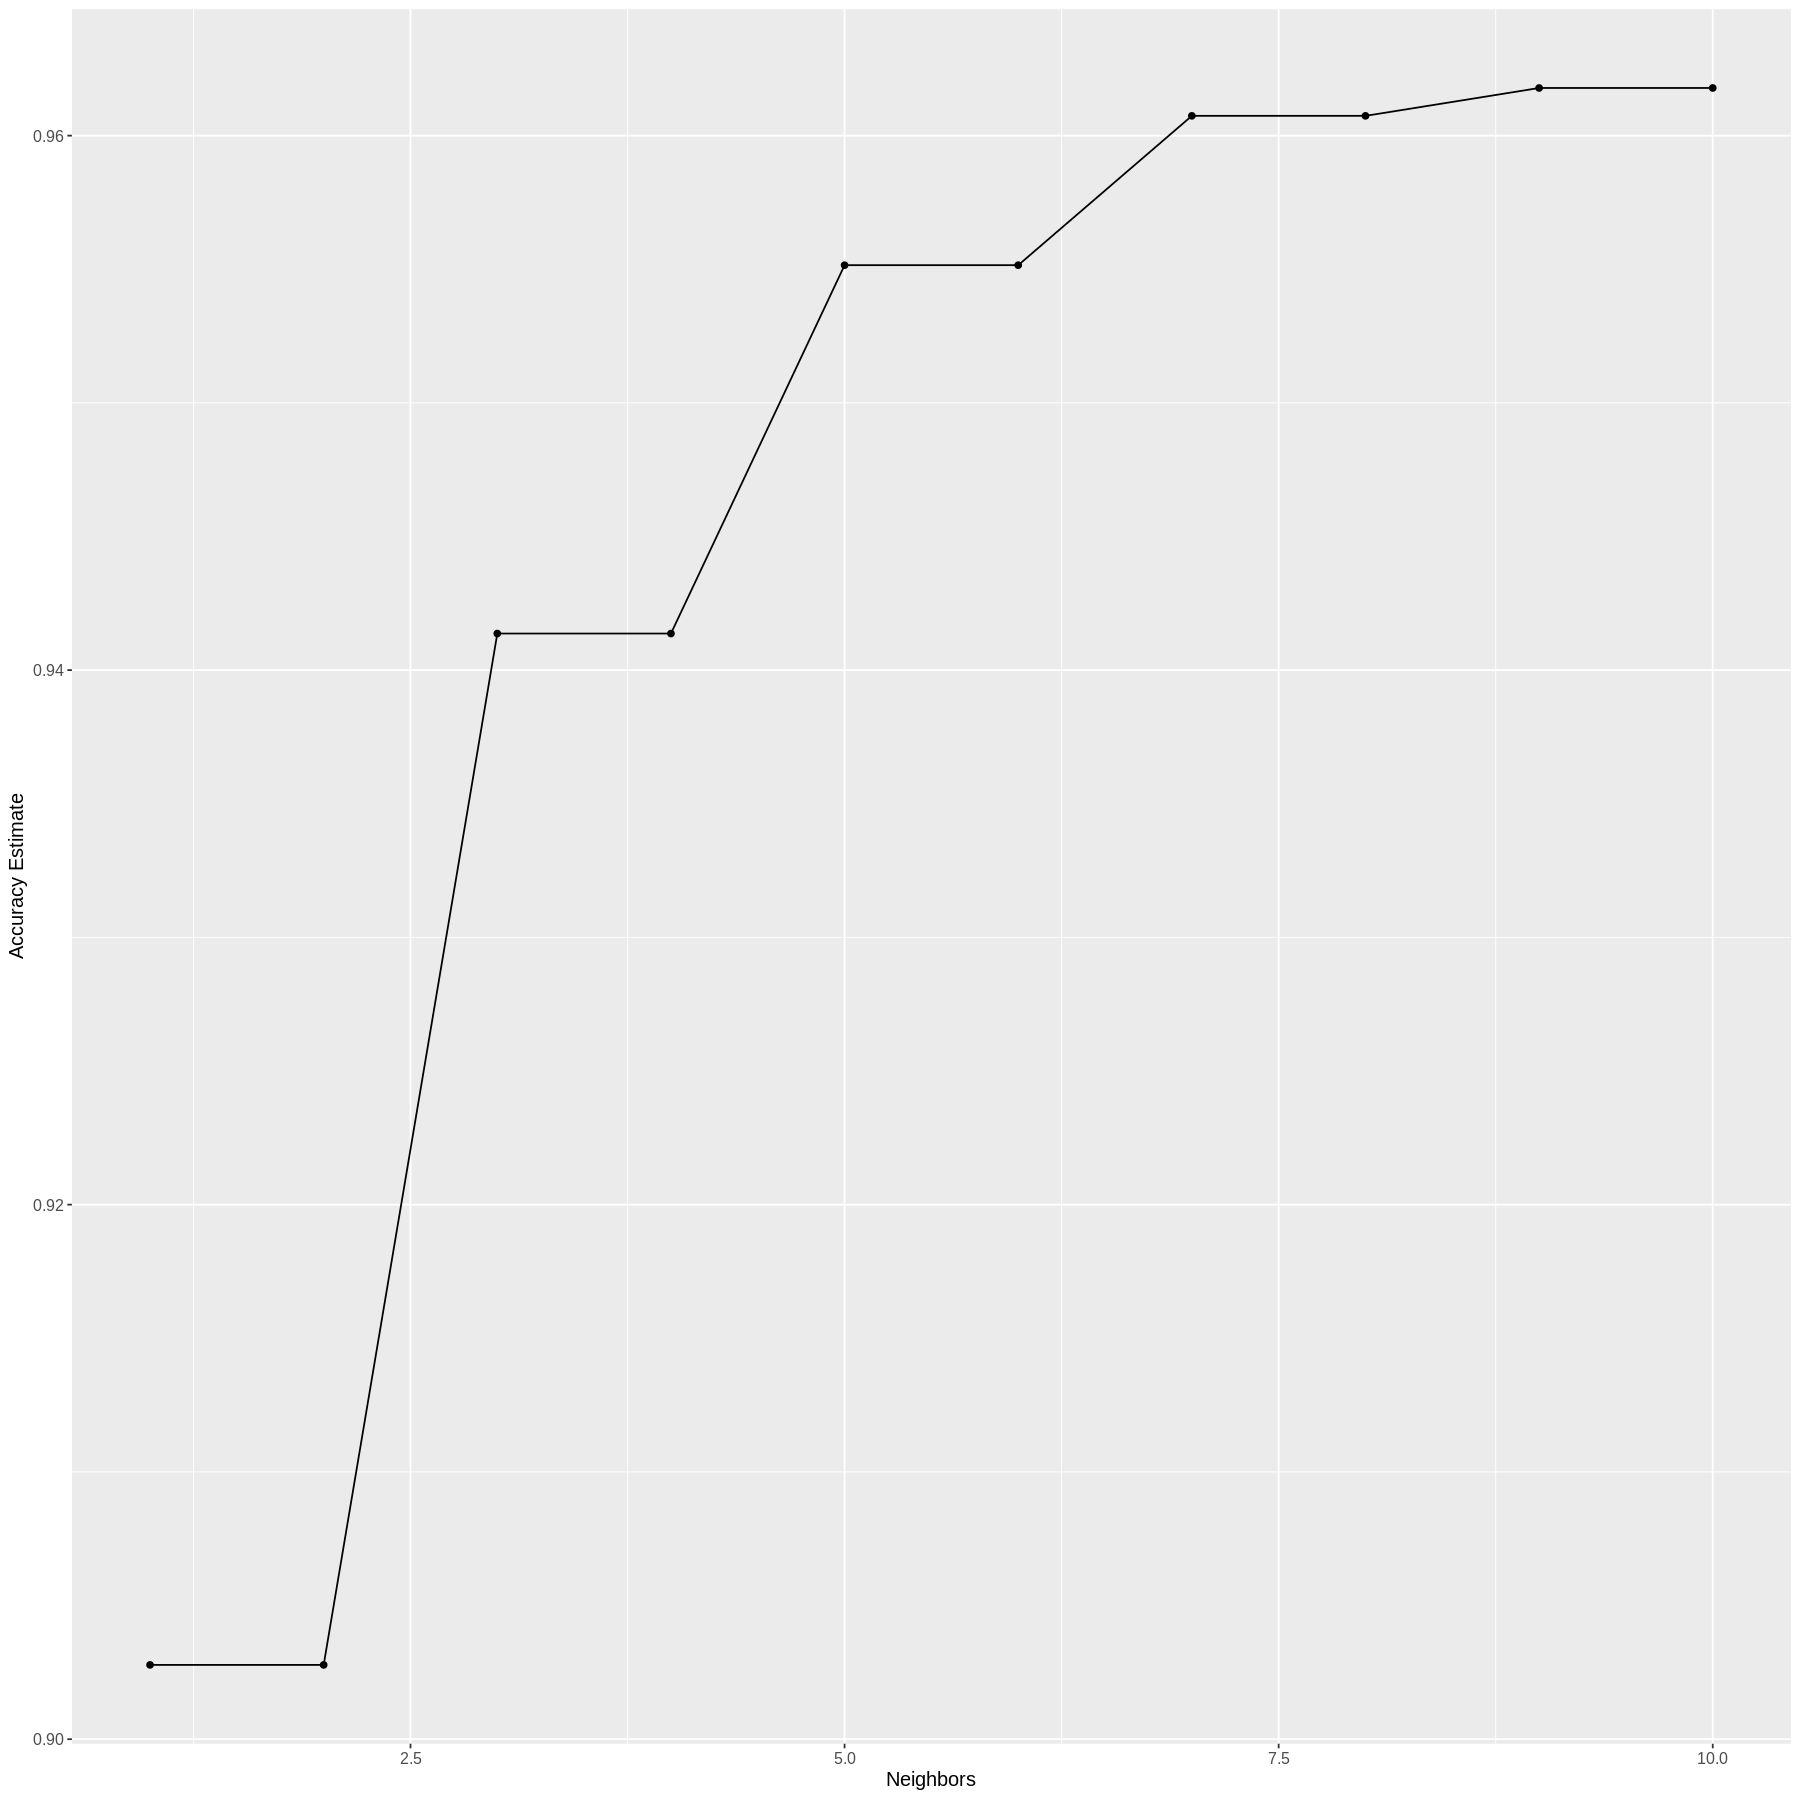

In [16]:
# WE ARE LOOKING AT K VALUES BETWEEN 1-10 FOR OUR MODEL
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# PUTTING OUR WORKFLOW TOGETHER WITH THE RECIPE (SCALED & NO PREP AND BAKE), MODEL SPEC, AND CROSS-VALIDATION 
pulsar_results <- workflow() %>%
  add_recipe(pulsar_recipe) %>% # recipe
  add_model(pulsar_spec) %>% # model spec with tune()
  tune_grid(resamples = pulsar_vfold, grid = k_vals) %>%
    collect_metrics()

pulsar_results

# GETTING ACCURACIES SO WE CAN PLOT AN ACCURACY VS K PLOT TO DETERMINE OUR IDEAL K 
accuracies <- pulsar_results %>%
  filter(.metric == "accuracy")

accuracies

# PLOTTING ACCURACY VS K 
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



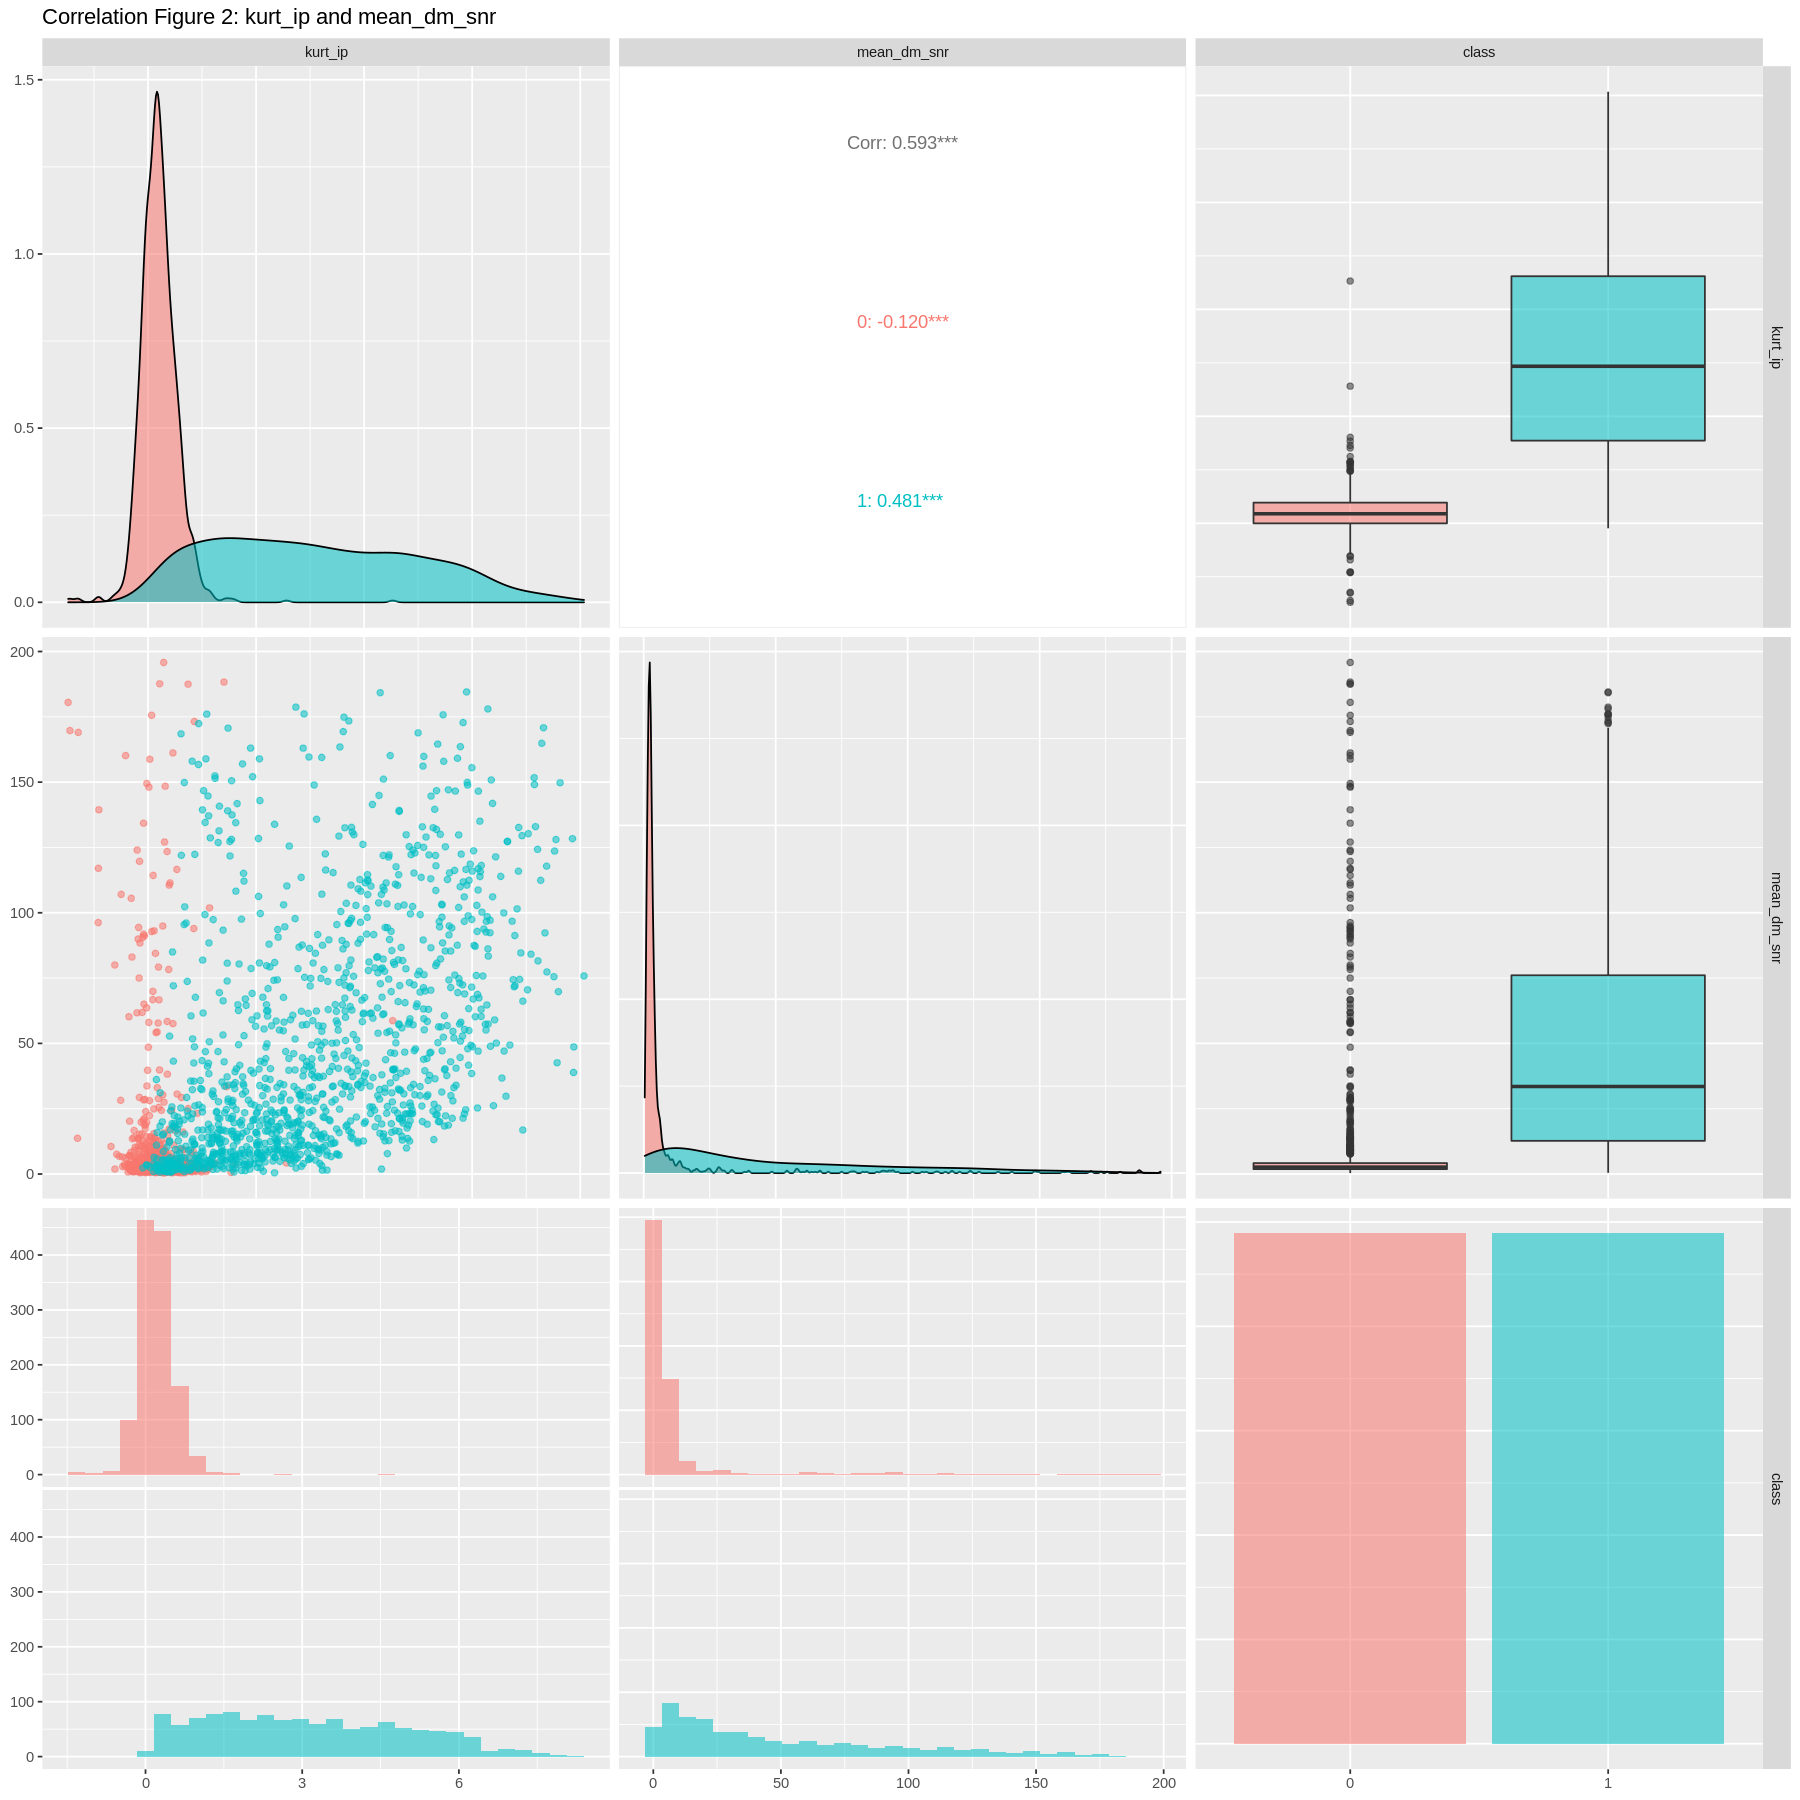

In [17]:
# LOOKING AT THE CORRELATION BETWEEN OUR TWO PREDICTOR VARIABLES: KURT_IP AND MEAN_DM_SNR FOR AN IDEA OF THE CLASS
# DISTRIBUTION IN OUR DOWNSAMPLED TRAINING DATA 
options(repr.plot.height = 15, repr.plot.width = 15)
correlation <- ggpairs(downsampled_pulsar_train, mapping = aes(color = class, alpha = 0.5)) +
    ggtitle("Correlation Figure 2: kurt_ip and mean_dm_snr")
correlation

In [18]:
# PULLING ACCURACY FOR K=8 (OUR CHOSEN K VALUE ACCORDING TO ACCURACIES VS K PLOT ABOVE) 
accuracy_for_8 <- accuracies %>%
        filter(neighbors == 8)
accuracy_for_8

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,accuracy,binary,0.9607393,5,0.001286213,Preprocessor1_Model08


In [19]:
# SPEC WITH OUR CHOSEN K VALUE 
pulsar_final_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 8) %>% 
  set_engine("kknn") %>%
  set_mode("classification")

# PUTTING OUR WORKFLOW TOGETHER WITH THE RECIPE (SCALED & NO PREP AND BAKE AND MODEL SPEC WITH K=4
pulsar_final_fit <- workflow() %>%
    add_recipe(pulsar_recipe) %>% 
    add_model(pulsar_final_spec) %>% 
    fit(data = pulsar_train)

# PREDICTING WITH PULSAR TEST SET, ADD COLUMN CORRECT (RETURN TRUE IF PREDICTION WAS RIGHT) 
prediction <- predict(pulsar_final_fit, pulsar_test) %>%
    bind_cols(pulsar_test) %>%
    mutate(Correct = (class == .pred_class))

prediction

# EVALUATING THE ACCURACY OF OUR MODEL WHEN PREDICTING ON OUR TEST SET 
test_set_accuracy <- prediction %>% 
  metrics(truth = class, estimate = .pred_class) %>% 
  filter(.metric == "accuracy") %>% 
  select(.estimate) %>% 
  pull() 

test_set_accuracy

# CONFUSION MATRIX OF OUR MODEL WHEN PREDICTION ON TEST SET 
conf_mat_test <- prediction %>% 
             conf_mat(truth = class, estimate = .pred_class)
conf_mat_test
                                      

.pred_class,mean_ip,std_ip,kurt_ip,skew_ip,mean_dm_snr,std_dm_snr,kurt_dm_snr,skew_dm_snr,class,Correct
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
0,140.56250,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0,TRUE
0,88.72656,40.67223,0.6008661,1.1234917,1.178930,11.46872,14.269573,252.56731,0,TRUE
0,142.07812,45.28807,-0.3203284,0.2839525,5.376254,29.00990,6.076266,37.83139,0,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,90.14844,40.78604,0.45713856,0.88551621,5.3545150,29.759511,6.102231,37.97952,0,TRUE
0,121.37500,53.24516,0.10377221,-0.36511875,1.0953177,12.239976,16.258042,303.88002,0,TRUE
0,118.48438,50.60848,-0.02905883,-0.02749376,0.4222408,8.086684,27.446113,830.63855,0,TRUE


[1] 0.9642458

          Truth
Prediction    0    1
         0 3931   32
         1  128  384

`summarise()` has grouped output by 'Correct'. You can override using the
`.groups` argument.


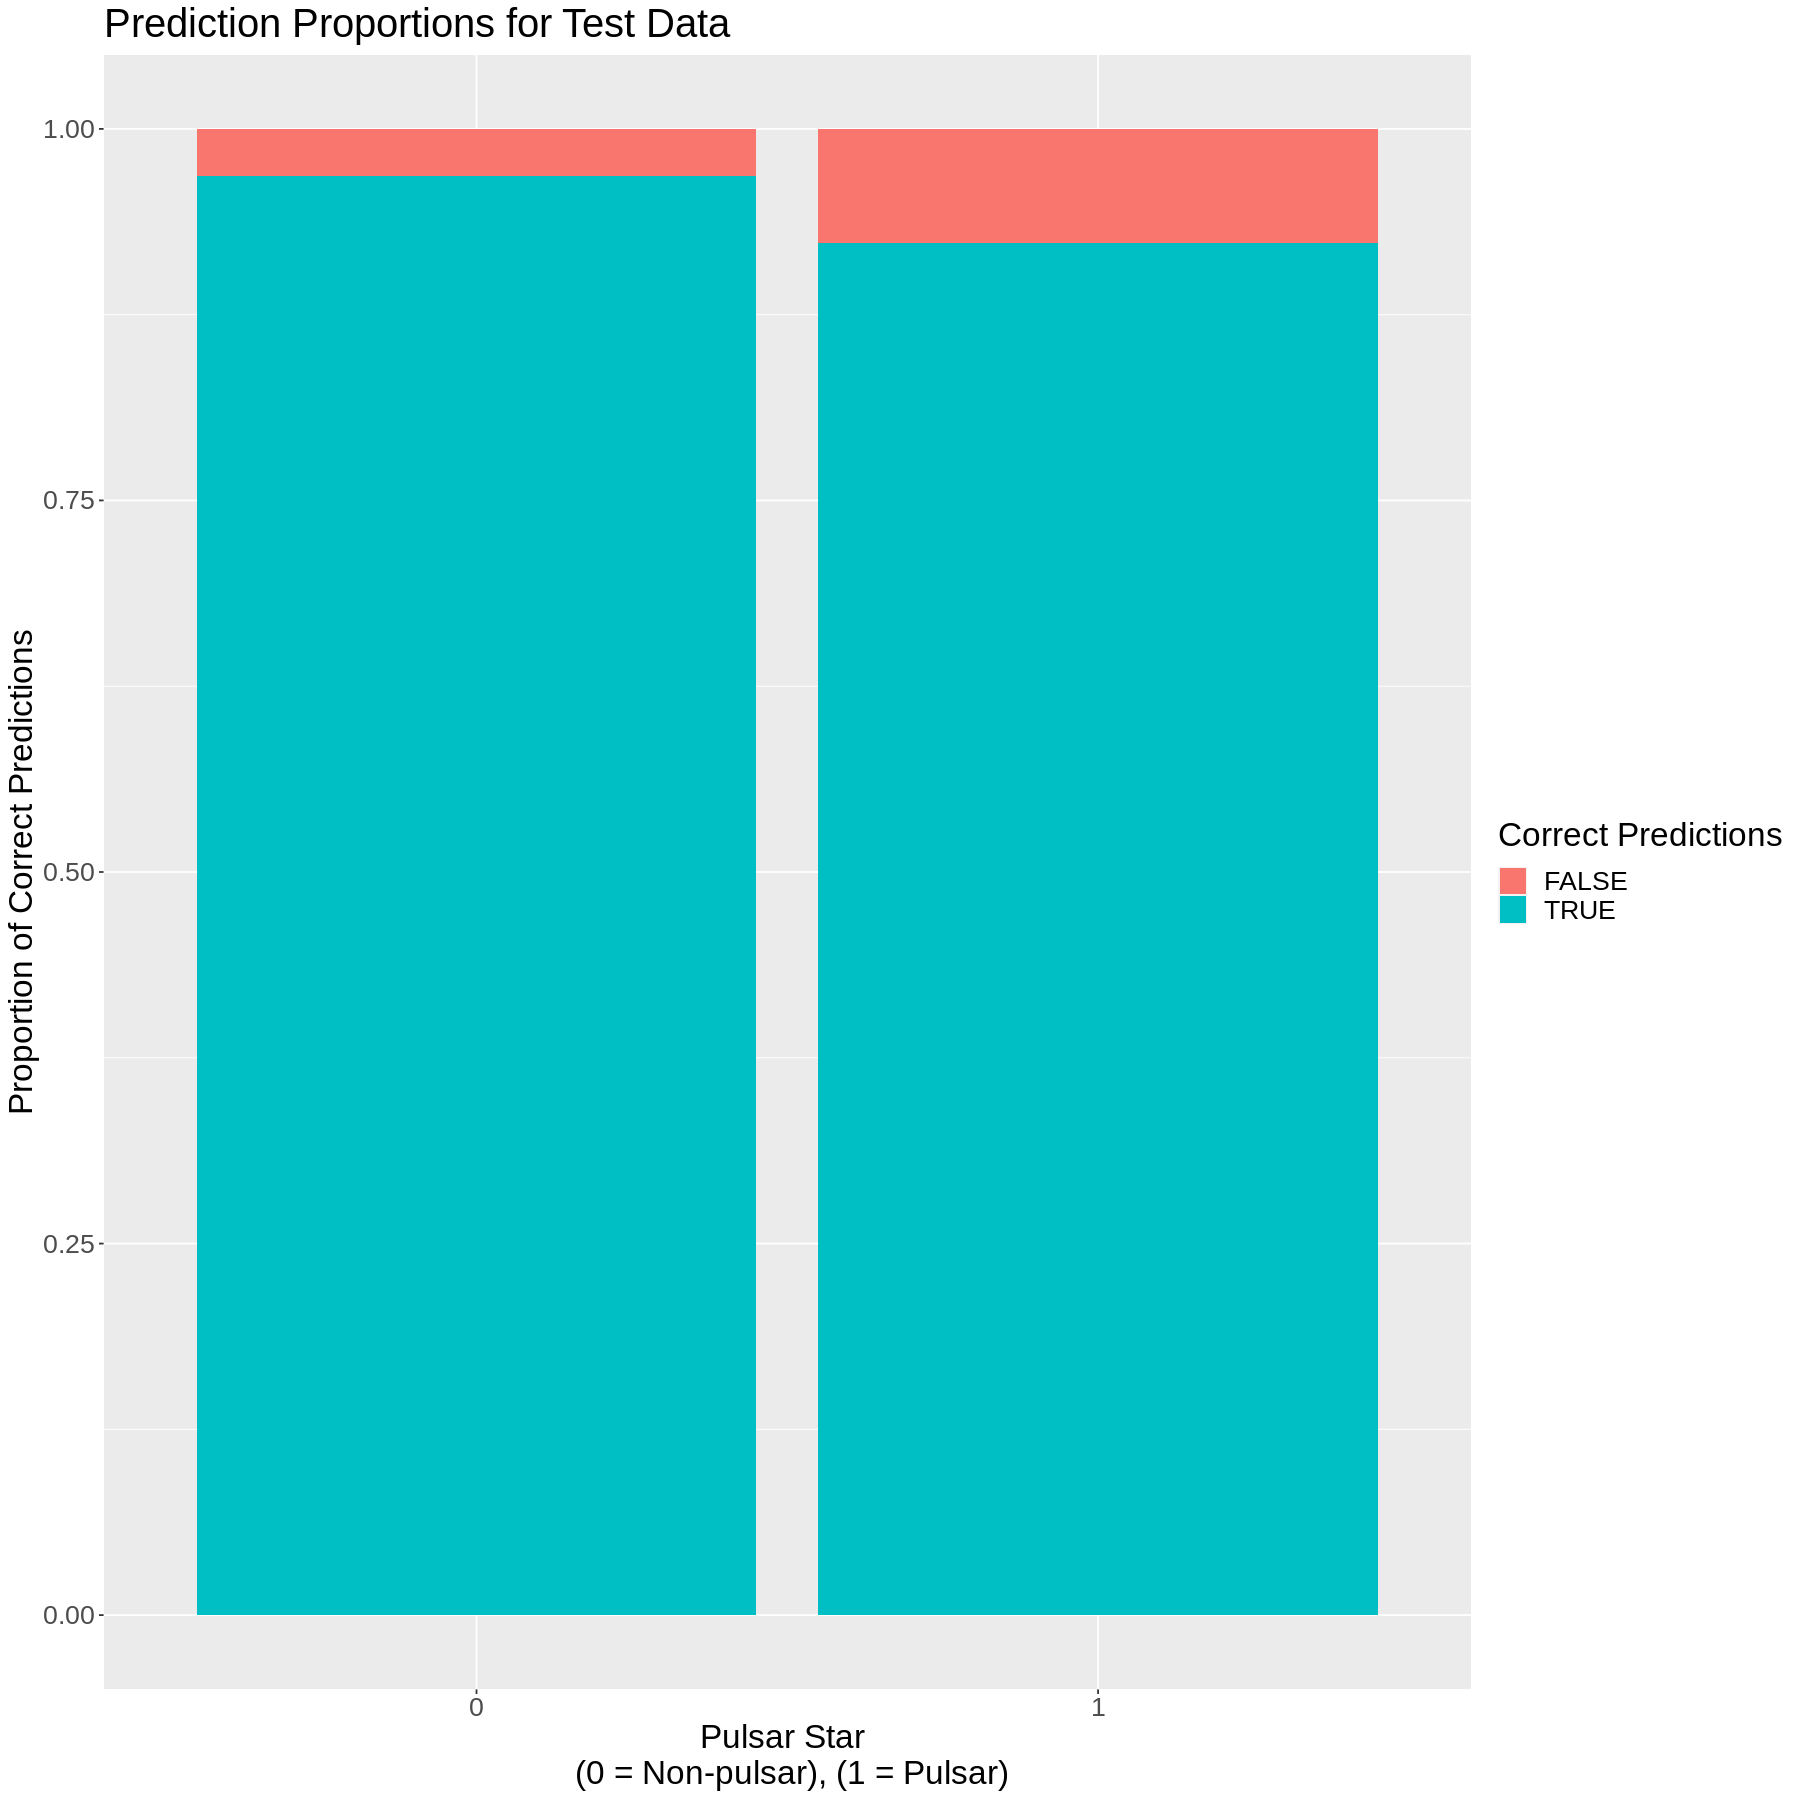

In [20]:
# FINAL VISUALIZATION OF OUR ANALYSIS; LOOKING AT THE PROPORTION OF OUR PREDICTIONS ON TEST DATA THAT ARE CORRECT
prediction_data <- prediction %>%
    mutate(Correct = as_factor(Correct)) %>%
    group_by(Correct, class) %>%
    summarize(count = n(), prop = count/ nrow(prediction))

proportions_plot <- ggplot(prediction_data, aes(x=class, y=count, fill = as_factor(Correct)))+
    geom_bar(position = "fill", stat = "identity") + 
    labs (fill = "Correct Predictions") +
    theme (text = element_text(size = 20)) +
    xlab("Pulsar Star \n (0 = Non-pulsar), (1 = Pulsar)") + 
    ylab("Proportion of Correct Predictions") +
    ggtitle("Prediction Proportions for Test Data")

proportions_plot

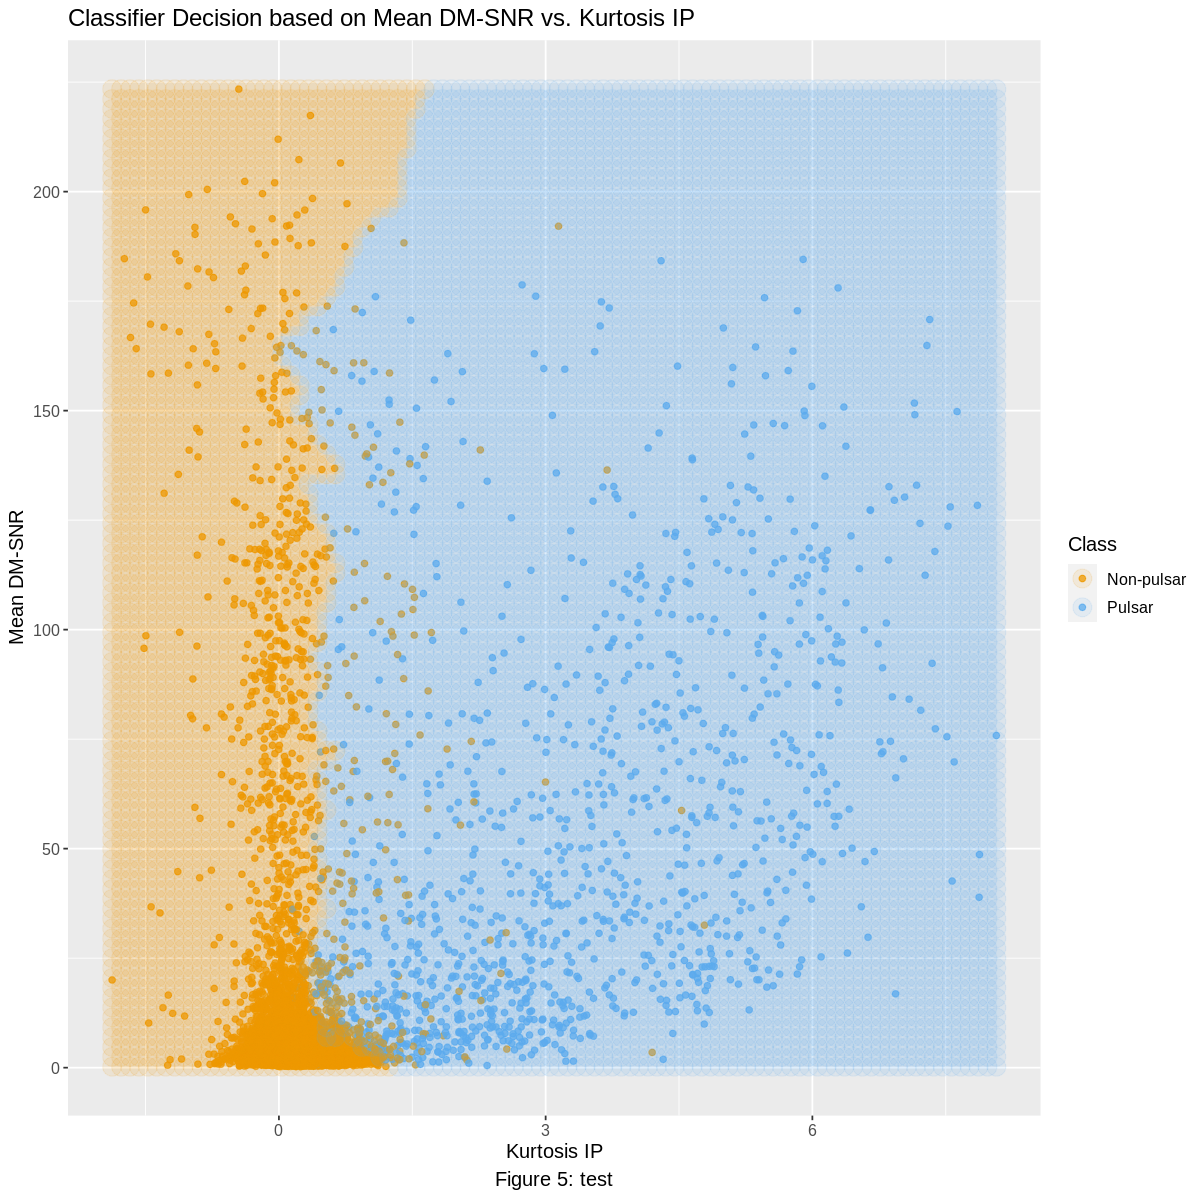

In [21]:
# FINAL VISUALIZATION OF THE ANALYSIS, LOOKING AT HOW OUR CLASSIFIER WORKS WITH PREDICTOR VARIABLES KURT_IP 
# AND MEAN_DM_SNR 

options(repr.plot.height = 10, repr.plot.width = 10)

kurt_ip_grid <- seq(min(pulsar_train$kurt_ip), 
                max(pulsar_train$kurt_ip), 
                length.out = 100)

mean_dm_snr_grid <- seq(min(pulsar_train$mean_dm_snr), 
                max(pulsar_train$mean_dm_snr), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(kurt_ip = kurt_ip_grid, 
                                mean_dm_snr = mean_dm_snr_grid))

knnPredGrid <- predict(pulsar_final_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(class = .pred_class)

wkflw_plot <-
  ggplot() +
  geom_point(data = pulsar_train, 
             mapping = aes(x = kurt_ip, 
                           y = mean_dm_snr, 
                           color = class), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = kurt_ip, 
                           y = mean_dm_snr, 
                           color = class), 
             alpha = 0.1, 
             size = 5) +
  labs(color = "Class", 
       x = "Kurtosis IP", 
       y = "Mean DM-SNR",
       caption = "Figure 5: test") +
  ggtitle("Classifier Decision based on Mean DM-SNR vs. Kurtosis IP") +
  scale_color_manual(labels = c("Non-pulsar", "Pulsar"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12),
        plot.caption = element_text(hjust = 0.5, size = 12))

wkflw_plot
